In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image


# U-Net 아키텍처의 다운 샘플링(Down Sampling) 모듈
class UNetDown(nn.Module):
    def __init__(self, in_channels, out_channels, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        # 너비와 높이가 2배씩 감소
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# U-Net 아키텍처의 업 샘플링(Up Sampling) 모듈: Skip Connection 사용
class UNetUp(nn.Module):
    def __init__(self, in_channels, out_channels, dropout=0.0):
        super(UNetUp, self).__init__()
        # 너비와 높이가 2배씩 증가
        layers = [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)]
        layers.append(nn.InstanceNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1) # 채널 레벨에서 합치기(concatenation)

        return x

# U-Net 생성자(Generator) 아키텍처
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False) # 출력: [64 X 128 X 128]

        self.down2 = UNetDown(64, 128) # 출력: [128 X 64 X 64]
        self.down3 = UNetDown(128, 256) # 출력: [256 X 32 X 32]
        self.down4 = UNetDown(256, 512, dropout=0.5) # 출력: [512 X 16 X 16]
        self.down5 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 8 X 8]
        self.down6 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 4 X 4]
        self.down7 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down8 = UNetDown(512, 512, dropout=0.5) # 출력: [512 X 2 X 2]
        self.down9 = UNetDown(512, 512, normalize=False, dropout=0.5) # 출력: [512 X 1 X 1]

        # Skip Connection 사용(출력 채널의 크기 X 2 == 다음 입력 채널의 크기)
        self.up1 = UNetUp(512, 512, dropout=0.5) # 출력: [1024 X 2 X 2]
        self.up2 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up3 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 4 X 4]
        self.up4 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 8 X 8]
        self.up5 = UNetUp(1024, 512, dropout=0.5) # 출력: [1024 X 16 X 16]
        self.up6 = UNetUp(1024, 256) # 출력: [512 X 32 X 32]
        self.up7 = UNetUp(512, 128) # 출력: [256 X 64 X 64]
        self.up8 = UNetUp(256, 64) # 출력: [128 X 128 X 128]

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2), # 출력: [128 X 256 X 256]
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, kernel_size=4, padding=1), # 출력: [3 X 256 X 256]
            nn.Tanh(),
        )

    def forward(self, x):
        # 인코더부터 디코더까지 순전파하는 U-Net 생성자(Generator)
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        d9 = self.down9(d8)
        u1 = self.up1(d9, d8)
        u2 = self.up2(u1, d7)
        u3 = self.up3(u2, d6)
        u4 = self.up4(u3, d5)
        u5 = self.up5(u4, d4)
        u6 = self.up6(u5, d3)
        u7 = self.up7(u6, d2)
        u8 = self.up8(u7, d1)

        return self.final(u8)


def generate_image(input_path, output_path, model_path):
    generator = GeneratorUNet()
    generator.cuda()

    # 모델의 가중치를 불러옵니다.
    generator.load_state_dict(torch.load(model_path))
    generator.eval()  # 평가 모드로 변경합니다.

    # 입력 이미지를 불러옵니다.
    image = Image.open(input_path)


    # 이미지의 채널 수를 확인합니다.
    num_channels = len(image.getbands())

    # 이미지가 그레이스케일인 경우
    if num_channels == 1:
        image = image.convert('RGB')

    # 이미지가 RGBA인 경우
    elif num_channels == 4:
        image = image.convert('RGB')

    # 이미지가 이미 RGB인 경우
    elif num_channels == 3:
        image = image


    # 이미지 변환(transform)을 적용합니다.
    transform = transforms.Compose([
        transforms.Resize((1024, 1024), Image.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = transform(image).unsqueeze(0).cuda()  # 배치 차원을 추가하고 GPU에 올립니다.

    # 이미지를 생성합니다.
    with torch.no_grad():
        generated_image = generator(image)

    # 생성된 이미지를 저장하기 위해 처리합니다.
    generated_image = (generated_image + 1) / 2  # [-1, 1] 범위를 [0, 1] 범위로 변경합니다.
    save_image(generated_image, output_path)

# 함수 호출
generate_image("./infe/APT_FP_OBJ_997579028.jpg", "./infe/Answer_222.jpg", "Pix2Pix_Generator_size1024_1028.pt")


c:\Users\user\miniforge3\envs\plan\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:

from PIL import Image

# 입력 이미지를 불러옵니다.
image = Image.open("./infe/Answer_222.jpg")


    # 이미지의 채널 수를 확인합니다.
num_channels = image.getbands()
print(len(num_channels))
print(num_channels)

3
('R', 'G', 'B')


In [7]:
image2 = np.array(image)
image2

array([[[155, 155, 155],
        [191, 191, 191],
        [176, 176, 176],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[207, 207, 207],
        [247, 247, 247],
        [236, 236, 236],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[209, 209, 209],
        [253, 253, 253],
        [247, 247, 247],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[205, 205, 205],
        [254, 254, 254],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[204, 204, 204],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[198, 198, 198],
        [251, 251, 251],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

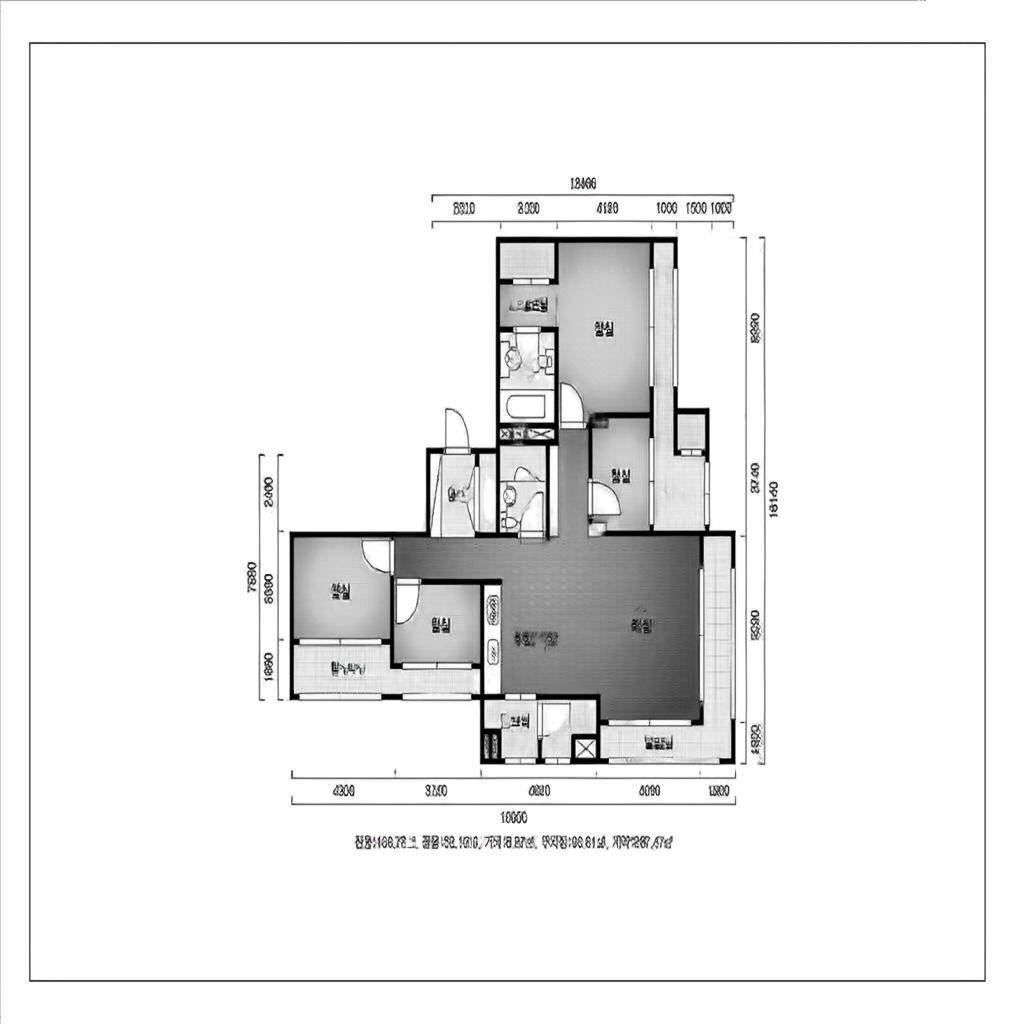

In [8]:
image